In [1]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.optimize import curve_fit

In [2]:
path = Path.cwd()
datapath = path / 'spectroscopydata'
outputpath = path / 'spectroscopyresults'

In [139]:
u = 1.6605 * 1e-27
m85 = 84.91 * u	
m87 = 86.91 * u	 
c = 299792458
kB = 1.380649 * 1e-23

In [138]:
def lorentzian(x,A,mean,gamma):
    return A/(1+4*(x-mean)**2/gamma**2)

def shifted_lorentzian(x,A,mean,gamma,offset):
    return lorentzian(x,A,mean,gamma)+offset

def gaussian(x,A,mean,std):
    return -A/np.sqrt(2*np.pi*std**2)*np.exp(-0.5*(x-mean)**2/std**2)

def shifted_gaussian(x,A,mean,std,offset,slope):
    return gaussian(x,A,mean,std)+offset+slope*x

def global_gaussian(x,A1,A2,A3,A4,mean1,mean2,mean3,mean4,std1,std2,std3,std4,offset,slope):
    return gaussian(x,A1,mean1,std1)+gaussian(x,A2,mean2,std2)+gaussian(x,A3,mean3,std3)+gaussian(x,A4,mean4,std4)+offset+slope*x

In [60]:
def set_mask(x,boundl,boundr):
    mask = np.logical_and(boundl < x, x < boundr)
    return mask

# Global Scan & Calibration

In [164]:
data = pd.read_csv(datapath/'DigiLock-ScopeData.txt', sep="\t")
data_nr = pd.read_csv(datapath/'DigiLock-ScopeData_norepump.txt', sep = "\t")
timebase = 50 * 1e-3
divisions = 4
timeaxis = np.linspace(0,divisions*timebase,len(data_nr['Aux out [V]']))

Text(0.5, 1.0, 'Repump off')

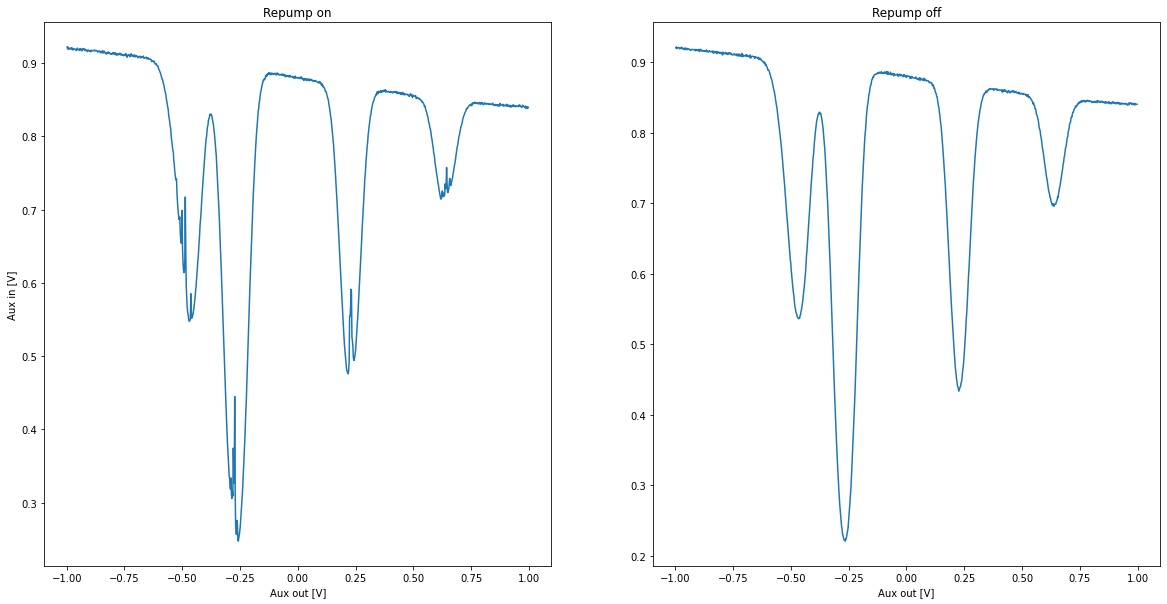

In [165]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (20,10))
ax1.plot(data['Aux out [V]'],data['Aux in [V]'])
ax2.plot(data_nr['Aux out [V]'],data_nr['Aux in [V]'],)
ax1.set_xlabel('Aux out [V]')
ax1.set_ylabel('Aux in [V]')
ax2.set_xlabel('Aux out [V]')
ax1.set_title('Repump on')
ax2.set_title('Repump off')

In [166]:
popt, pcov = curve_fit(global_gaussian,data_nr['Aux out [V]'],data_nr['Aux in [V]'],bounds=([0,0,0,0,-0.7,-0.4,0.1,0.5,0,0,0,0,0,-0.2],[1,1,1,1,-0.3,0,0.4,0.75,0.5,0.5,0.5,0.5,1,0]))
perr = np.sqrt(np.diag(pcov))

res = 0.211513
A1 = 0.04262 +/- 0.000172, mean1 = -0.47112 +/- 0.000192 ,std1 = 0.04656 +/- 0.000202
A2 = 0.07965 +/- 0.000166, mean2 = -0.26739 +/- 0.000100 ,std2 = 0.04583 +/- 0.000105
A3 = 0.04482 +/- 0.000155, mean3 = 0.22801 +/- 0.000147 ,std3 = 0.04066 +/- 0.000152
A4 = 0.01618 +/- 0.000166, mean4 = 0.63781 +/- 0.000415 ,std4 = 0.04124 +/- 0.000441
offset = 0.88000 +/- 0.000285, slope = -0.04186 +/- 0.000428


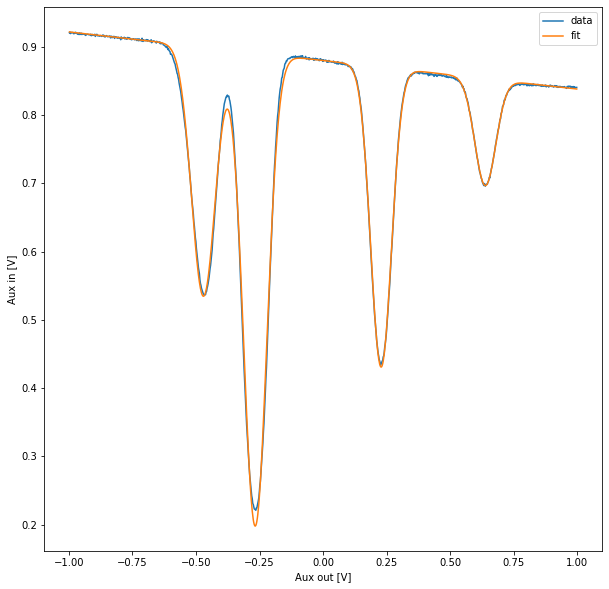

In [167]:
plt.figure(figsize = (10,10))
plt.plot(data_nr['Aux out [V]'],data_nr['Aux in [V]'],label='data')
plt.plot(data_nr['Aux out [V]'], global_gaussian(data_nr['Aux out [V]'],*popt),label='fit')
#plt.plot(data_nr['Aux out [V]'],popt[-1]*data_nr['Aux out [V]']+popt[-2])
plt.xlabel('Aux out [V]')
plt.ylabel('Aux in [V]')
plt.legend()
print("res = {:f}".format(np.sqrt(np.sum((global_gaussian(data_nr['Aux out [V]'],*popt)-data_nr['Aux in [V]'])**2))))
for i in range(0,4):
    print("A{:d} = {:.5f} +/- {:5f}, mean{:d} = {:.5f} +/- {:5f} ,std{:d} = {:.5f} +/- {:5f}".format(i+1,popt[i],perr[i],i+1,popt[i+4],perr[i+4],i+1,popt[i+8],perr[i+8]))
print("offset = {:.5f} +/- {:5f}, slope = {:.5f} +/- {:5f}".format(popt[-2],perr[-2],popt[-1],perr[-1]))

In [168]:
print("Use 87Rb F=2 -> F' and 87Rb F=1 -> F' for calibration.")
delta_t = (popt[7]-popt[4])
delta_t_err = np.sqrt(perr[7]**2+perr[4]**2)
print("Time difference: ({:f} +/- {:f}) s".format(delta_t,delta_t_err))
print("Literaturwert: 6.834682 GHz")
K = 6.834682/delta_t
K_err = 6.834682/delta_t**2 * delta_t_err
print("Kalibrierungsfaktor K = ({:.3f} +/- {:.3f}) GHz/s".format(K,K_err))

Use 87Rb F=2 -> F' and 87Rb F=1 -> F' for calibration.
Time difference: (1.108934 +/- 0.000457) s
Literaturwert: 6.834682 GHz
Kalibrierungsfaktor K = (6.163 +/- 0.003) GHz/s


In [169]:
print("Frequenzabstand 85Rb F=3 -> F':")
dt = (popt[5]-popt[4])
dt_err = np.sqrt(perr[5]**2+perr[4]**2) 
f = K * dt
f_err = np.sqrt((dt*K_err)**2+(K*dt_err)**2)
print("Messung: ({:.4f} +/- {:.4f}) GHz".format(f,f_err))
print("Theorie: 1.298 GHz")
print("rel. Abweichung: {:.2f}%".format((f-1.298)/1.298*100))

Frequenzabstand 85Rb F=3 -> F':
Messung: (1.2557 +/- 0.0014) GHz
Theorie: 1.298 GHz
rel. Abweichung: -3.26%


In [170]:
print("Frequenzabstand 85Rb F=2 -> F':")
dt = (popt[6]-popt[4])
dt_err = np.sqrt(perr[6]**2+perr[4]**2) 
f = K * dt
f_err = np.sqrt((dt*K_err)**2+(K*dt_err)**2)
print("Messung: ({:.4f} +/- {:.4f}) GHz".format(f,f_err))
print("Theorie: 4.33 GHz")
print("rel. Abweichung: {:.2f}%".format((f-4.33)/4.33*100))

Frequenzabstand 85Rb F=2 -> F':
Messung: (4.3089 +/- 0.0023) GHz
Theorie: 4.33 GHz
rel. Abweichung: -0.49%


# Natürliche Linienbreite

## 87 Rb F=2 --> F'

Text(0.5, 1.0, 'Repump off')

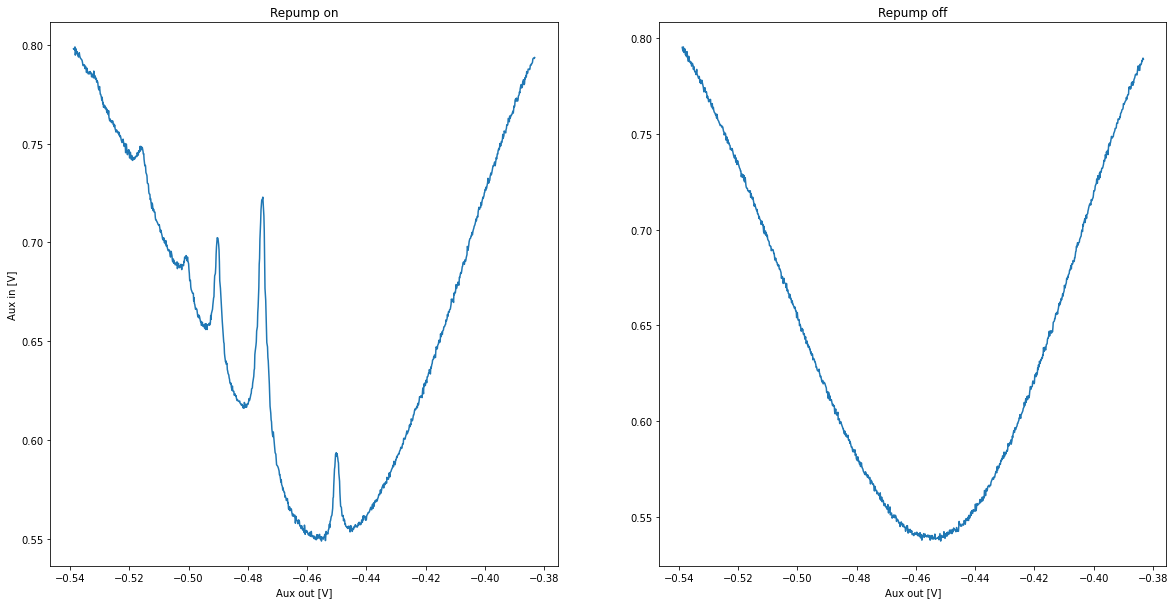

In [11]:
transition = "87_2"
data = pd.read_csv(datapath/('DigiLock-LockData_'+transition+'.txt'), sep="\t")
data_nr = pd.read_csv(datapath/('DigiLock-LockData_'+transition+'_norepump.txt'), sep = "\t")
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (20,10))
ax1.plot(data['Aux out [V]'],data['Aux in [V]'])
ax2.plot(data_nr['Aux out [V]'],data_nr['Aux in [V]'],)
ax1.set_xlabel('Aux out [V]')
ax1.set_ylabel('Aux in [V]')
ax2.set_xlabel('Aux out [V]')
ax1.set_title('Repump on')
ax2.set_title('Repump off')

In [97]:
popt, pcov = curve_fit(shifted_gaussian,data_nr['Aux out [V]'],data_nr['Aux in [V]'],bounds=([0,-0.5,0,0,-1],[1,-0.4,0.5,2,1]))
perr = np.sqrt(np.diag(pcov))
data_substracted = data['Aux in [V]']-shifted_gaussian(data['Aux out [V]'],*popt)

In [124]:
mask1 = set_mask(data['Aux out [V]'],-0.536,-0.526)
popt1, pcov1 = curve_fit(shifted_lorentzian,data['Aux out [V]'][mask1],data_substracted[mask1],bounds=([0,-0.536,0,0],[1,-0.526,0.5,1]))
perr1 = np.sqrt(np.diag(pcov1))

mask2 = set_mask(data['Aux out [V]'],-0.525,-0.505)
popt2, pcov2 = curve_fit(shifted_lorentzian,data['Aux out [V]'][mask2],data_substracted[mask2],bounds=([0,-0.525,0,0],[1,-0.505,0.5,1]))
perr2 = np.sqrt(np.diag(pcov2))

mask3 = set_mask(data['Aux out [V]'],-0.505,-0.495)
popt3, pcov3 = curve_fit(shifted_lorentzian,data['Aux out [V]'][mask3],data_substracted[mask3],bounds=([0,-0.505,0,0],[1,-0.49,0.5,1]))
perr3 = np.sqrt(np.diag(pcov3))

mask4 = set_mask(data['Aux out [V]'],-0.495,-0.485)
popt4, pcov4 = curve_fit(shifted_lorentzian,data['Aux out [V]'][mask4],data_substracted[mask4],bounds=([0,-0.5,0,0],[1,-0.48,0.5,1]))
perr4 = np.sqrt(np.diag(pcov4))

mask5 = np.logical_and(-0.48 < data['Aux out [V]'], data['Aux out [V]'] < -0.46)
popt5, pcov5 = curve_fit(shifted_lorentzian,data['Aux out [V]'][mask5],data_substracted[mask5],bounds=([0,-0.48,0,0],[1,-0.46,0.5,1]))
perr5 = np.sqrt(np.diag(pcov5))

mask6 = set_mask(data['Aux out [V]'],-0.455,-0.445)
popt6, pcov6 = curve_fit(shifted_lorentzian,data['Aux out [V]'][mask6],data_substracted[mask6],bounds=([0,-0.46,0,0],[1,-0.44,0.5,1]))
perr6 = np.sqrt(np.diag(pcov6))

Gaussian:
res = 0.047531
A = 0.04663 +/- 0.000219, mean = -0.45253 +/- 0.000050 ,std = 0.05012 +/- 0.000106
offset = 1.08475 +/- 0.002729, slope = 0.38466 +/- 0.004309

Lorentzian 1:
res = 0.007330
A = 0.00604 +/- 0.000408, mean = -0.53139 +/- 0.000088 ,gamma = 0.00317 +/- 0.000464, offset = 0.00469 +/- 0.000357

Lorentzian 2:
res = 0.025006
A = 0.02005 +/- 0.000805, mean = -0.51554 +/- 0.000063 ,gamma = 0.00319 +/- 0.000238, offset = 0.00951 +/- 0.000341

Lorentzian 3:
res = 0.016445
A = 0.01723 +/- 0.000911, mean = -0.50044 +/- 0.000062 ,gamma = 0.00255 +/- 0.000283, offset = 0.01772 +/- 0.000638

Lorentzian 4:
res = 0.014183
A = 0.06419 +/- 0.000779, mean = -0.49012 +/- 0.000014 ,gamma = 0.00257 +/- 0.000066, offset = 0.02177 +/- 0.000542

Lorentzian 5:
res = 0.039573
A = 0.13829 +/- 0.001186, mean = -0.47517 +/- 0.000016 ,gamma = 0.00377 +/- 0.000058, offset = 0.01380 +/- 0.000517

Lorentzian 6:
res = 0.011398
A = 0.04688 +/- 0.000649, mean = -0.45007 +/- 0.000015 ,gamma = 0.00234 

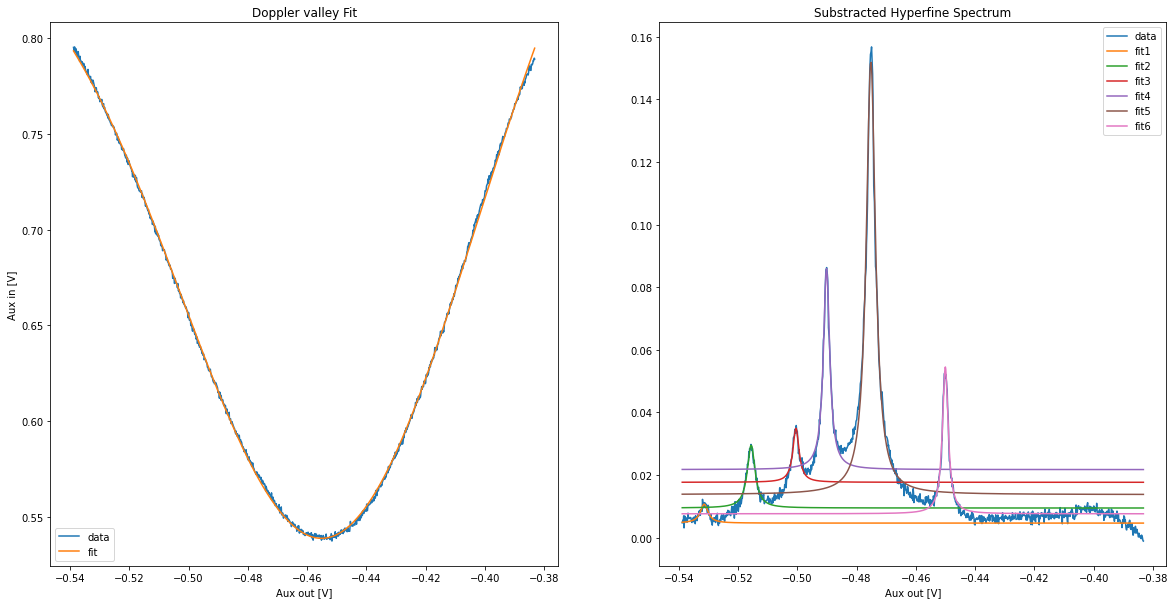

In [131]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (20,10))
ax1.plot(data_nr['Aux out [V]'],data_nr['Aux in [V]'],label='data')
ax1.plot(data_nr['Aux out [V]'], shifted_gaussian(data_nr['Aux out [V]'],*popt),label='fit')

ax2.plot(data['Aux out [V]'],data_substracted,label='data')
ax2.plot(data['Aux out [V]'],shifted_lorentzian(data['Aux out [V]'],*popt1),label='fit1')
ax2.plot(data['Aux out [V]'],shifted_lorentzian(data['Aux out [V]'],*popt2),label='fit2')
ax2.plot(data['Aux out [V]'],shifted_lorentzian(data['Aux out [V]'],*popt3),label='fit3')
ax2.plot(data['Aux out [V]'],shifted_lorentzian(data['Aux out [V]'],*popt4),label='fit4')
ax2.plot(data['Aux out [V]'],shifted_lorentzian(data['Aux out [V]'],*popt5),label='fit5')
ax2.plot(data['Aux out [V]'],shifted_lorentzian(data['Aux out [V]'],*popt6),label='fit6')

ax1.set_xlabel('Aux out [V]')
ax1.set_ylabel('Aux in [V]')
ax2.set_xlabel('Aux out [V]')
ax1.set_title('Doppler valley Fit')
ax2.set_title('Substracted Hyperfine Spectrum')
ax1.legend()
ax2.legend()

print("Gaussian:")
print("res = {:f}".format(np.sqrt(np.sum((shifted_gaussian(data_nr['Aux out [V]'],*popt)-data_nr['Aux in [V]'])**2))))
print("A = {:.5f} +/- {:5f}, mean = {:.5f} +/- {:5f} ,std = {:.5f} +/- {:5f}".format(popt[0],perr[0],popt[1],perr[1],popt[2],perr[2]))
print("offset = {:.5f} +/- {:5f}, slope = {:.5f} +/- {:5f}\n".format(popt[-2],perr[-2],popt[-1],perr[-1]))
print('Lorentzian 1:')
print("res = {:f}".format(np.sqrt(np.sum((shifted_lorentzian(data['Aux out [V]'][mask1],*popt1)-data_substracted[mask1])**2))))
print("A = {:.5f} +/- {:5f}, mean = {:.5f} +/- {:5f} ,gamma = {:.5f} +/- {:5f}, offset = {:.5f} +/- {:5f}\n".format(popt1[0],perr1[0],popt1[1],perr1[1],popt1[2],perr1[2],popt1[3],perr1[3]))
print('Lorentzian 2:')
print("res = {:f}".format(np.sqrt(np.sum((shifted_lorentzian(data['Aux out [V]'][mask2],*popt2)-data_substracted[mask2])**2))))
print("A = {:.5f} +/- {:5f}, mean = {:.5f} +/- {:5f} ,gamma = {:.5f} +/- {:5f}, offset = {:.5f} +/- {:5f}\n".format(popt2[0],perr2[0],popt2[1],perr2[1],popt2[2],perr2[2],popt2[3],perr2[3]))
print('Lorentzian 3:')
print("res = {:f}".format(np.sqrt(np.sum((shifted_lorentzian(data['Aux out [V]'][mask3],*popt3)-data_substracted[mask3])**2))))
print("A = {:.5f} +/- {:5f}, mean = {:.5f} +/- {:5f} ,gamma = {:.5f} +/- {:5f}, offset = {:.5f} +/- {:5f}\n".format(popt3[0],perr3[0],popt3[1],perr3[1],popt3[2],perr3[2],popt3[3],perr3[3]))
print('Lorentzian 4:')
print("res = {:f}".format(np.sqrt(np.sum((shifted_lorentzian(data['Aux out [V]'][mask4],*popt4)-data_substracted[mask4])**2))))
print("A = {:.5f} +/- {:5f}, mean = {:.5f} +/- {:5f} ,gamma = {:.5f} +/- {:5f}, offset = {:.5f} +/- {:5f}\n".format(popt4[0],perr4[0],popt4[1],perr4[1],popt4[2],perr4[2],popt4[3],perr4[3]))
print('Lorentzian 5:')
print("res = {:f}".format(np.sqrt(np.sum((shifted_lorentzian(data['Aux out [V]'][mask5],*popt5)-data_substracted[mask5])**2))))
print("A = {:.5f} +/- {:5f}, mean = {:.5f} +/- {:5f} ,gamma = {:.5f} +/- {:5f}, offset = {:.5f} +/- {:5f}\n".format(popt5[0],perr5[0],popt5[1],perr5[1],popt5[2],perr5[2],popt5[3],perr5[3]))
print('Lorentzian 6:')
print("res = {:f}".format(np.sqrt(np.sum((shifted_lorentzian(data['Aux out [V]'][mask6],*popt6)-data_substracted[mask6])**2))))
print("A = {:.5f} +/- {:5f}, mean = {:.5f} +/- {:5f} ,gamma = {:.5f} +/- {:5f}, offset = {:.5f} +/- {:5f}\n".format(popt6[0],perr6[0],popt6[1],perr6[1],popt6[2],perr6[2],popt6[3],perr6[3]))

In [161]:
print("Use F' 2\&3 crossover and F' 1\&3 crossover for calibration.")
delta_t = (popt5[1]-popt4[1])
delta_t_err = np.sqrt(perr5[1]**2+perr4[1]**2)
print("Time difference: ({:f} +/- {:f}) s".format(delta_t,delta_t_err))
print("Literaturwert: 78.47 MHz")
K = 78.47/delta_t
K_err = 78.47/delta_t**2 * delta_t_err
print("Kalibrierungsfaktor K = ({:.3f} +/- {:.3f}) MHz/V".format(K,K_err))

Use F' 2\&3 crossover and F' 1\&3 crossover for calibration.
Time difference: (0.014952 +/- 0.000021) s
Literaturwert: 78.47 MHz
Kalibrierungsfaktor K = (5247.989 +/- 7.423) MHz/V


In [162]:
print("Dopplerverbreiterung:")
sigma_V = popt[2]
sigma_V_err = perr[2]

sigma = K * sigma_V
sigma_err = np.sqrt((sigma_V*K_err)**2+(K*sigma_V_err)**2)

mean = 384.2304844685 * 1e6 - 2.563005979089109 *1e3 #MHz
mean_err = np.sqrt((0.0000000062 * 1e6)**2 + (0.000000000000034 * 1e3)**2) #MHz


T = (sigma/mean)**2 * m87*c**2/kB
T_err = np.sqrt((2*sigma/mean**2 * sigma_err)**2+(2*sigma**2/mean**3 * mean_err)**2) * m87*c**2/kB


print("Temperatur: ({:.4f} +/- {:.4f}) K".format(T,T_err))

print('\nNatürliche Linienbreite:')

gammaf1 = K * popt1[2]
gammaf2 = K * popt3[2]
gammaf3 = K * popt6[2]

gammaf1_err = np.sqrt((K*perr1[2])**2 + (popt1[1]*K_err)**2)
gammaf2_err = np.sqrt((K*perr3[2])**2 + (popt3[1]*K_err)**2)
gammaf3_err = np.sqrt((K*perr6[2])**2 + (popt6[1]*K_err)**2)

print('Theorie: 6.067 MHz')
print("87Rb F=2 -> F'=1: ({:.4f} +/- {:.4f}) MHz, rel. Abweichung: {:.2f}%".format(gammaf1,gammaf1_err,(gammaf1-6.067)/6.067*100))
print("87Rb F=2 -> F'=2: ({:.4f} +/- {:.4f}) MHz, rel. Abweichung: {:.2f}%".format(gammaf2,gammaf2_err,(gammaf2-6.067)/6.067*100))
print("87Rb F=2 -> F'=3: ({:.4f} +/- {:.4f}) MHz, rel. Abweichung: {:.2f}%".format(gammaf3,gammaf3_err,(gammaf3-6.067)/6.067*100))


Dopplerverbreiterung:
Temperatur: (440.3086 +/- 2.2345) K

Natürliche Linienbreite:
Theorie: 6.067 MHz
87Rb F=2 -> F'=1: (16.6536 +/- 4.6359) MHz, rel. Abweichung: 174.50%
87Rb F=2 -> F'=2: (13.3667 +/- 4.0006) MHz, rel. Abweichung: 120.32%
87Rb F=2 -> F'=3: (12.2811 +/- 3.3594) MHz, rel. Abweichung: 102.42%


## 85 Rb F=3 --> F'

Text(0.5, 1.0, 'Repump off')

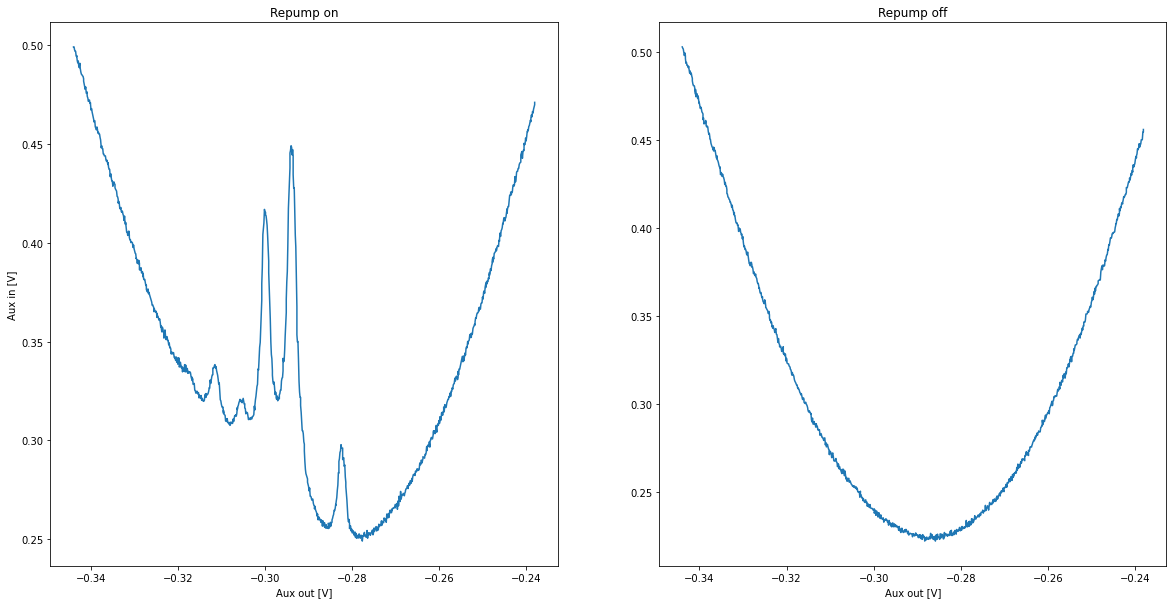

In [77]:
transition = "85_3"
data = pd.read_csv(datapath/('DigiLock-LockData_'+transition+'.txt'), sep="\t")
data_nr = pd.read_csv(datapath/('DigiLock-LockData_'+transition+'_norepump.txt'), sep = "\t")
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (20,10))
ax1.plot(data['Aux out [V]'],data['Aux in [V]'])
ax2.plot(data_nr['Aux out [V]'],data_nr['Aux in [V]'],)
ax1.set_xlabel('Aux out [V]')
ax1.set_ylabel('Aux in [V]')
ax2.set_xlabel('Aux out [V]')
ax1.set_title('Repump on')
ax2.set_title('Repump off')

In [80]:
popt, pcov = curve_fit(shifted_gaussian,data_nr['Aux out [V]'],data_nr['Aux in [V]'],bounds=([0,-0.4,0,0,-1],[1,-0.2,0.5,2,1]))
perr = np.sqrt(np.diag(pcov))

In [ ]:
mask = set_mask(data['Aux out [V]'],-0.455,-0.445)
poptt, pcovt = curve_fit(shifted_lorentzian,data['Aux out [V]'][mask],data_substracted[mask],bounds=([0,-0.46,0,0],[1,-0.44,0.5,1]))
plt.plot(data['Aux out [V]'][mask],data_substracted[mask])
plt.plot(data['Aux out [V]'][mask],shifted_lorentzian(data['Aux out [V]'][mask],*poptt))

res = 0.044464
A = 0.32383 +/- 0.011269, mean = -0.28231 +/- 0.000258 ,std = 0.08615 +/- 0.001044
offset = 2.00000 +/- 0.045624, slope = 0.97320 +/- 0.047922


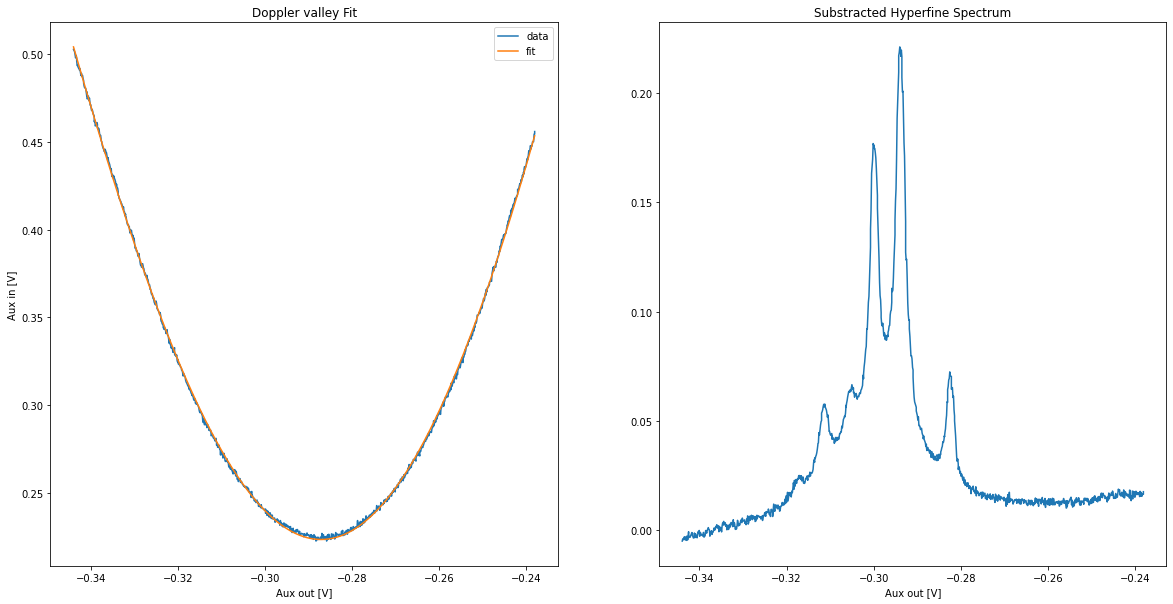

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (20,10))
ax1.plot(data_nr['Aux out [V]'],data_nr['Aux in [V]'],label='data')
ax1.plot(data_nr['Aux out [V]'], shifted_gaussian(data_nr['Aux out [V]'],*popt),label='fit')

ax2.plot(data['Aux out [V]'],data['Aux in [V]']-shifted_gaussian(data['Aux out [V]'],*popt))

ax1.set_xlabel('Aux out [V]')
ax1.set_ylabel('Aux in [V]')
ax2.set_xlabel('Aux out [V]')
ax1.set_title('Doppler valley Fit')
ax2.set_title('Substracted Hyperfine Spectrum')
ax1.legend()
print("res = {:f}".format(np.sqrt(np.sum((shifted_gaussian(data_nr['Aux out [V]'],*popt)-data_nr['Aux in [V]'])**2))))
print("A = {:.5f} +/- {:5f}, mean = {:.5f} +/- {:5f} ,std = {:.5f} +/- {:5f}".format(popt[0],perr[0],popt[1],perr[1],popt[2],perr[2]))
print("offset = {:.5f} +/- {:5f}, slope = {:.5f} +/- {:5f}".format(popt[-2],perr[-2],popt[-1],perr[-1]))

In [98]:
mask1 = (data['Aux out [V]'] > -0.32)
mask1[mask1 == True]

0      True
1      True
2      True
3      True
4      True
       ... 
995    True
996    True
997    True
998    True
999    True
Name: Aux out [V], Length: 1000, dtype: bool

In [99]:
data['Aux out [V]']

0      0.44198
1      0.44210
2      0.44235
3      0.44247
4      0.44259
        ...   
995    0.58738
996    0.58750
997    0.58762
998    0.58787
999    0.58799
Name: Aux out [V], Length: 1000, dtype: float64

## 85 Rb F=2 --> F'

Text(0.5, 1.0, 'Repump off')

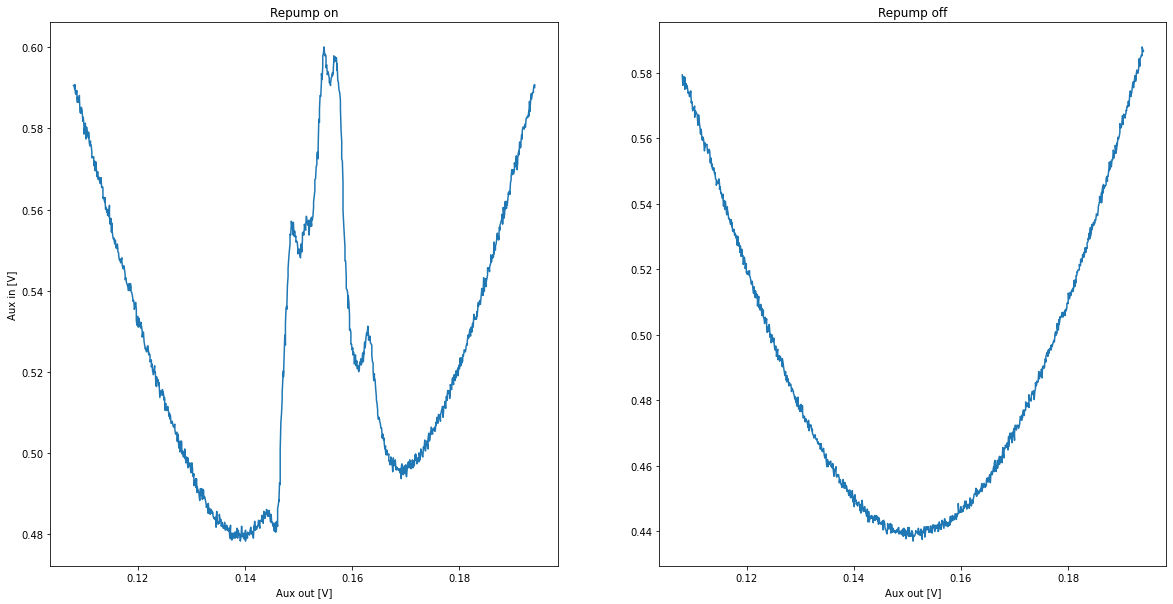

In [82]:
transition = "85_2"
data = pd.read_csv(datapath/('DigiLock-LockData_'+transition+'.txt'), sep="\t")
data_nr = pd.read_csv(datapath/('DigiLock-LockData_'+transition+'_norepump.txt'), sep = "\t")
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (20,10))
ax1.plot(data['Aux out [V]'],data['Aux in [V]'])
ax2.plot(data_nr['Aux out [V]'],data_nr['Aux in [V]'],)
ax1.set_xlabel('Aux out [V]')
ax1.set_ylabel('Aux in [V]')
ax2.set_xlabel('Aux out [V]')
ax1.set_title('Repump on')
ax2.set_title('Repump off')

In [84]:
popt, pcov = curve_fit(shifted_gaussian,data_nr['Aux out [V]'],data_nr['Aux in [V]'],bounds=([0,0.1,0,0,-1],[1,0.2,0.5,2,1]))
perr = np.sqrt(np.diag(pcov))

res = 0.033636
A = 0.07546 +/- 0.002037, mean = 0.15357 +/- 0.000118 ,std = 0.05480 +/- 0.000537
offset = 0.92522 +/- 0.008682, slope = 0.41386 +/- 0.018219


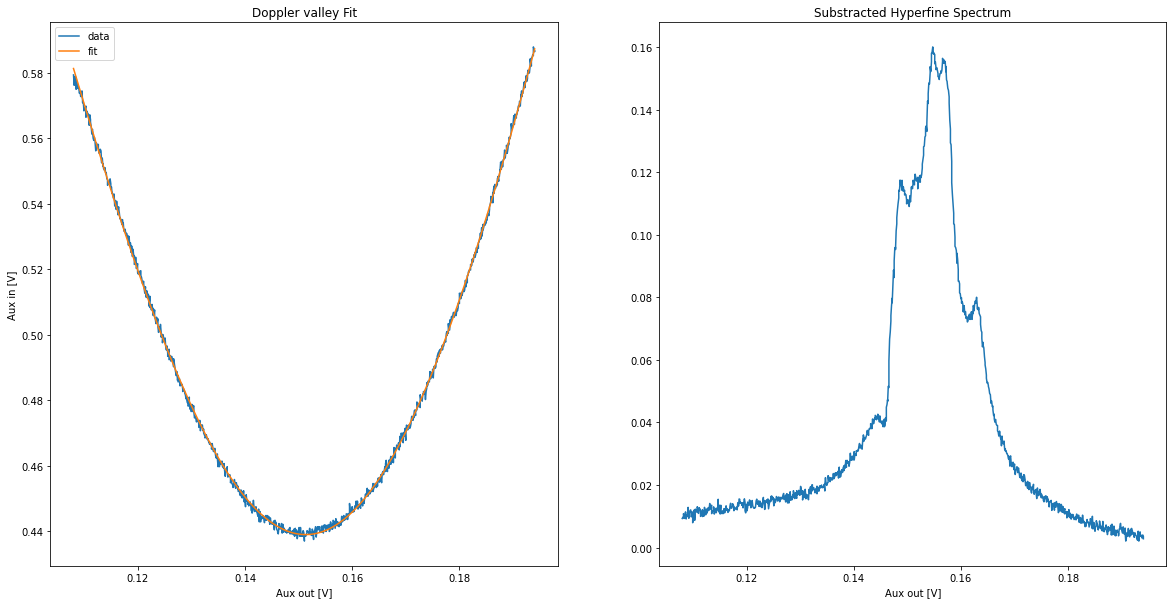

In [85]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (20,10))
ax1.plot(data_nr['Aux out [V]'],data_nr['Aux in [V]'],label='data')
ax1.plot(data_nr['Aux out [V]'], shifted_gaussian(data_nr['Aux out [V]'],*popt),label='fit')

ax2.plot(data['Aux out [V]'],data['Aux in [V]']-shifted_gaussian(data['Aux out [V]'],*popt))

ax1.set_xlabel('Aux out [V]')
ax1.set_ylabel('Aux in [V]')
ax2.set_xlabel('Aux out [V]')
ax1.set_title('Doppler valley Fit')
ax2.set_title('Substracted Hyperfine Spectrum')
ax1.legend()
print("res = {:f}".format(np.sqrt(np.sum((shifted_gaussian(data_nr['Aux out [V]'],*popt)-data_nr['Aux in [V]'])**2))))
print("A = {:.5f} +/- {:5f}, mean = {:.5f} +/- {:5f} ,std = {:.5f} +/- {:5f}".format(popt[0],perr[0],popt[1],perr[1],popt[2],perr[2]))
print("offset = {:.5f} +/- {:5f}, slope = {:.5f} +/- {:5f}".format(popt[-2],perr[-2],popt[-1],perr[-1]))

## 87 Rb F=1 --> F'

Text(0.5, 1.0, 'Repump off')

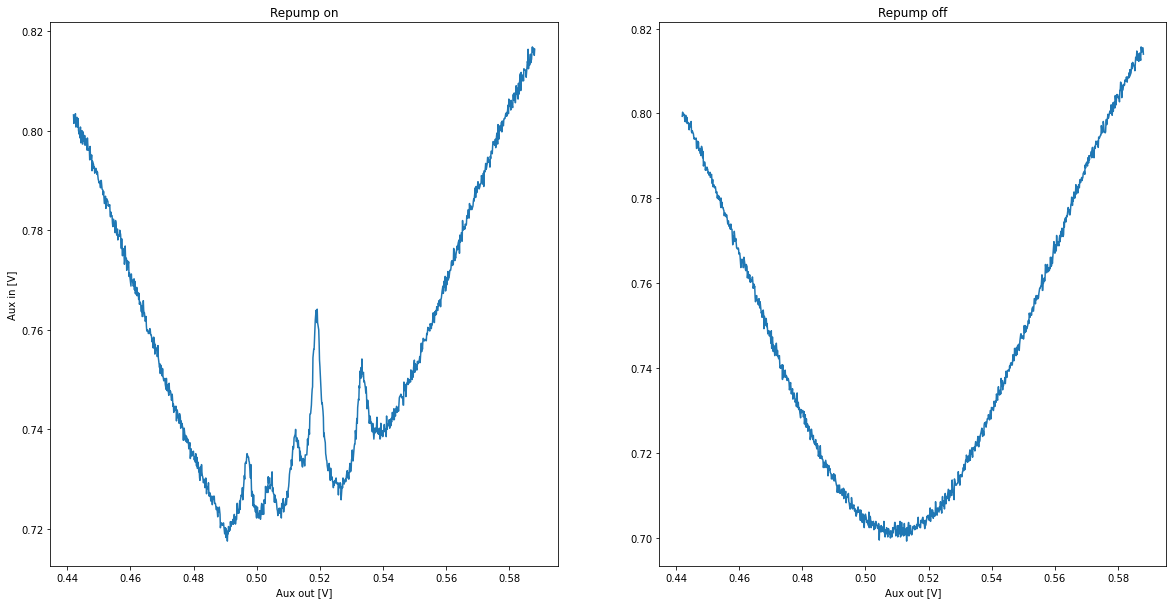

In [86]:
transition = "87_1"
data = pd.read_csv(datapath/('DigiLock-LockData_'+transition+'.txt'), sep="\t")
data_nr = pd.read_csv(datapath/('DigiLock-LockData_'+transition+'_norepump.txt'), sep = "\t")
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (20,10))
ax1.plot(data['Aux out [V]'],data['Aux in [V]'])
ax2.plot(data_nr['Aux out [V]'],data_nr['Aux in [V]'],)
ax1.set_xlabel('Aux out [V]')
ax1.set_ylabel('Aux in [V]')
ax2.set_xlabel('Aux out [V]')
ax1.set_title('Repump on')
ax2.set_title('Repump off')

In [89]:
popt, pcov = curve_fit(shifted_gaussian,data_nr['Aux out [V]'],data_nr['Aux in [V]'],bounds=([0,0.4,0,0,-1],[1,0.6,0.5,2,1]))
perr = np.sqrt(np.diag(pcov))

res = 0.029942
A = 0.01800 +/- 0.000123, mean = 0.50950 +/- 0.000065 ,std = 0.04682 +/- 0.000146
offset = 0.86096 +/- 0.001687, slope = -0.01291 +/- 0.002548


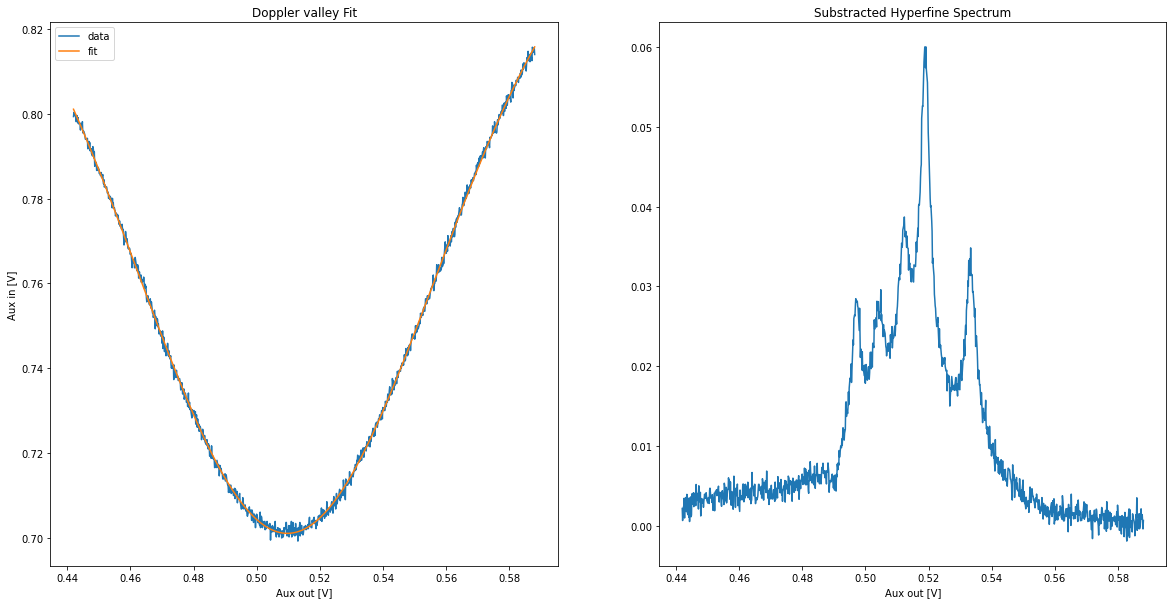

In [90]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (20,10))
ax1.plot(data_nr['Aux out [V]'],data_nr['Aux in [V]'],label='data')
ax1.plot(data_nr['Aux out [V]'], shifted_gaussian(data_nr['Aux out [V]'],*popt),label='fit')

ax2.plot(data['Aux out [V]'],data['Aux in [V]']-shifted_gaussian(data['Aux out [V]'],*popt))

ax1.set_xlabel('Aux out [V]')
ax1.set_ylabel('Aux in [V]')
ax2.set_xlabel('Aux out [V]')
ax1.set_title('Doppler valley Fit')
ax2.set_title('Substracted Hyperfine Spectrum')
ax1.legend()
print("res = {:f}".format(np.sqrt(np.sum((shifted_gaussian(data_nr['Aux out [V]'],*popt)-data_nr['Aux in [V]'])**2))))
print("A = {:.5f} +/- {:5f}, mean = {:.5f} +/- {:5f} ,std = {:.5f} +/- {:5f}".format(popt[0],perr[0],popt[1],perr[1],popt[2],perr[2]))
print("offset = {:.5f} +/- {:5f}, slope = {:.5f} +/- {:5f}".format(popt[-2],perr[-2],popt[-1],perr[-1]))